#Tomato, Tomato: A Fresh Take
#####Just how much is a fresh tomato rating worth?

<img src="image.png">

###Overview and Motivation

Rotten Tomatoes© is a well-known review aggregator, collecting critic and audience reviews and reporting the percentage that are positive, or "freshness." Those with reviews 60% positive or higher are "Fresh," and those at 59% or below are "Rotten." The freshness and corresponding icon -- a fresh red tomato or a splattered rotten one -- are displayed with each movie on Rotten Tomatoes, allowing visitors to the website to quickly see how the movie is being received.

Even before a movie is released, critics have the chance to preview the film and review it. Rotten Tomatoes provides this information so that audiences can decide whether or not it's worth it to see the blockbuster opening Friday. But how exactly do moviegoers decide? Perhaps it's the freshness rating that drives audiences - the John may only see movies rated 80% or higher. Or, like Jane, who buys tickets to all "fresh" movies,  does an illustrated tomato sway them?

After a movie is released, the movie is then open to audience reviews. These reviews have no impact on the freshness of a movie -- rather, they simply allow for moviegoers to know how other average Joes feel about the movie instead of critics.

Though there is in actuality very little difference between 59% freshness and 60%, the fact that one is deemed "rotten" and one "fresh" may have great influence on attendance and, therefore, profit. The analysis conducted in *Tomato, Tomato* investigates this problem to determine the impact of fresh and rotten categorization when a movie is on the verge of freshness. Ultimately, we will seek to quantify the impact of two small, cartoonish icons on multibillion dollar ventures.

The project itself is highly influenced by the contributions of Economics Ph.D candidate Daniel Sullivan, a tutor in Dunster House. Though this project has its roots in behavioral economics, its findings could be applicable to marketers, who may be incentivized to campaign just that much harder for a positive review,  or encourage the use of similar iconography in advertising. Moreover, findings about the degree of influence of theatergoers versus critic ratings on profit may incite producers to gear their movies towards a specific demographic. 

###Initial Questions and Data

The aims of this project are as follows:

- To apply techniques learned in Computer Science 109 in conducting high level analysis
- To determine the significance of the relationship between Rotten Tomato© ratings and movie profitability
- To determine the impact of being rated "fresh" or "rotten" on profitability

The data used in this project is taken from two different sources. First, we needed to scrape the budget and profit information of the movies. This was taken from www.the-numbers.com, a website dedictated to providing accurate data on money in the movie industry. Second, we needed to acquire the ratings from the Rotten Tomatoes© website. This was scraped from the API provided by Rotten Tomatoes© and then cleaned to fit our purposes. We will explain the exact processes of these two data acquistions in later sections.

In [105]:
#Import libraries needed
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
from collections import defaultdict
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
import json
import urllib
from configobj import ConfigObj

Our first step will be to scrape the movie budget data from www.the-numbers.com. To do so, we first will request the website, and then use BeautifulSoup to turn the text into a parsable object. Afterwards, we will scrape the necessary information. For this project, that inclues movie title, budget rank, budget, domestic gross revenue, worldwide gross revenue, domestic profit, and total profits.

In [33]:
#here we access the webpage and download the content using requests
movie_list=requests.get("http://www.the-numbers.com/movie/budgets/all")

In [106]:
#create BeautifulSoup object to scrape
soup = BeautifulSoup(movie_list.text, "html.parser")
datarows = soup.find_all("td", attrs={"class": "data"})
titlerows = soup.find_all("b")[1:]
titles = [row.get_text() for row in titlerows]
titles = titles[:len(titles)-3]

#create dictionary from scraped data
moviedict = {}
for i, title in enumerate(titles):
    vals = datarows[i*4:(i*4)+4]
    newvals = []
    for val in vals:
        exp = r'((?<=\d),(?=\d))|(\$(?=\d))'
        newvals.append(re.sub(exp,r'',val.get_text()))
    moviedict[title] = [int(val) for val in newvals]

#create dataframe from dict
movieframe = pd.DataFrame.from_dict(moviedict, orient = 'index')
movieframe.columns = ['budget_rank','budget','domestic_gross','worldwide_gross']
movieframe.sort('budget_rank', inplace = True)
movieframe = movieframe[movieframe.domestic_gross > 0]
movieframe['dom_profits'] = map(lambda dom, budget: dom - budget, movieframe['domestic_gross'], movieframe['budget'])
movieframe['total_profits'] = map(lambda world, budget: world - budget, movieframe['worldwide_gross'], movieframe['budget'])

Now let's look at our results. If done correctly, we should have a dataframe containing the columns named above, sorted by budget size and indexed by movie title.

In [107]:
movieframe.head()

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits
Avatar,1,425000000,760507625,2783918982,335507625,2358918982
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425
Spectre,3,300000000,185745058,793245058,-114254942,493245058
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090


Next we scrape Rotten Tomatoes rating data from the API and add it to our data frame. First, we define a function movie_details, which takes movie title strings as arguments, to scrape the relevant info from the API. This function is then applied over our list of movie titles and added to our data frame.

In [43]:
#API scraping function
def movie_details(title):
    new_title = title.replace(" ", "+")
    url = "http://api.rottentomatoes.com/api/public/v1.0/movies.json?apikey=dagqdghwaq3e3mxyrp7kmmj5&q=%s&page_limit=2" % (new_title)
    res = requests.get(url)
    time.sleep(.2)
    js = json.loads(res.content)
    if js["movies"] != []:
        movie = js["movies"][0]
        ratings = movie["ratings"]
        if ratings["critics_score"] != -1:
            dates = movie["release_dates"]
            critic_score = ratings["critics_score"]
            aud_score = ratings["audience_score"]
            if "theater" not in dates:
                date = "NA"
                return critic_score, aud_score, date
            else:
                date = dates["theater"]
                return critic_score, aud_score, date
        else:
            movie = js["movies"][1]
            ratings = movie["ratings"]
            dates = movie["release_dates"]
            critic_score = ratings["critics_score"]
            aud_score = ratings["audience_score"]
            if "theater" not in dates:
                date = "NA"
                return critic_score, aud_score, date
            else:
                date = dates["theater"]
                return critic_score, aud_score, date
    else:
        return None, None, None

In [44]:
movies = movieframe.index
movieframe["critic_rating"] = 0
movieframe["aud_rating"] = 0
movieframe["release_date"] = ""

for movie in movies:
    crit, aud, date = movie_details(movie)
    movieframe.loc[movieframe.index.isin([movie]), "critic_rating"] = crit
    movieframe.loc[movieframe.index.isin([movie]), "aud_rating"] = aud
    movieframe.loc[movieframe.index.isin([movie]), "release_date"] = date
    
movieframe

IndexError: list index out of range

To prevent from having to call the API too often, we save the information to a .csv file for future use.

In [23]:
#movieframe.to_csv("movieframe.csv", encoding='utf-8')

Next we clean the data, dropping N/As and -1s in the ratings. Results are displayed below.

In [130]:
movieframe = pd.DataFrame.from_csv("movieframe.csv")
movieframe.dropna(inplace = True)
movieframe = movieframe[movieframe['critic_rating'] >= 0]
movieframe = movieframe[movieframe['release_date'] != "NA"]
movieframe.drop('rating', axis=1, inplace=True)
movieframe

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,critic_rating,aud_rating,release_date
Avatar,1,425000000,760507625,2783918982,335507625,2358918982,143.581086,21.627229,20.102344,83,82,2009-12-18
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425,131.607401,20.466915,19.169082,45,72,2007-05-25
Spectre,3,300000000,178416219,751916219,-121583781,451916219,131.607401,20.147664,18.201996,64,66,2015-11-06
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099,128.775479,20.639764,19.742651,87,90,2012-07-20
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090,128.775479,18.374010,16.602448,31,51,2013-07-03
John Carter,6,275000000,73058679,282778100,-201941321,7778100,128.775479,18.588128,-4.605171,51,60,2012-03-09
Tangled,7,260000000,200821936,586581936,-59178064,326581936,126.982343,19.895517,18.776698,90,87,2010-11-24
Spider-Man 3,8,258000000,336530303,890875303,78530303,632875303,126.737439,20.426645,19.451983,63,51,2007-05-04
The Avengers: Age of Ultron,9,250000000,459005868,1404705868,209005868,1154705868,125.743343,20.958461,19.833975,74,85,2015-05-01
Harry Potter and the Half-Blood Prince,11,250000000,301959197,935083686,51959197,685083686,125.743343,20.494524,19.352453,83,77,2009-07-15


With all our data aggregated into a flat format, we go on to perform exploratory data analysis and begin the model building process.

##EDA on Budget & Rating Data

Here we start by visualizing the distributions of our different variables: budget, total profit, domestic profit, etc. For modelng purposes, it is desirable to work with variables whose distributions are approximately normal, leading us to apply transformations to those variables whose distributions are severely skewed. 

Below we investigate the distribution of movie budget sizes.

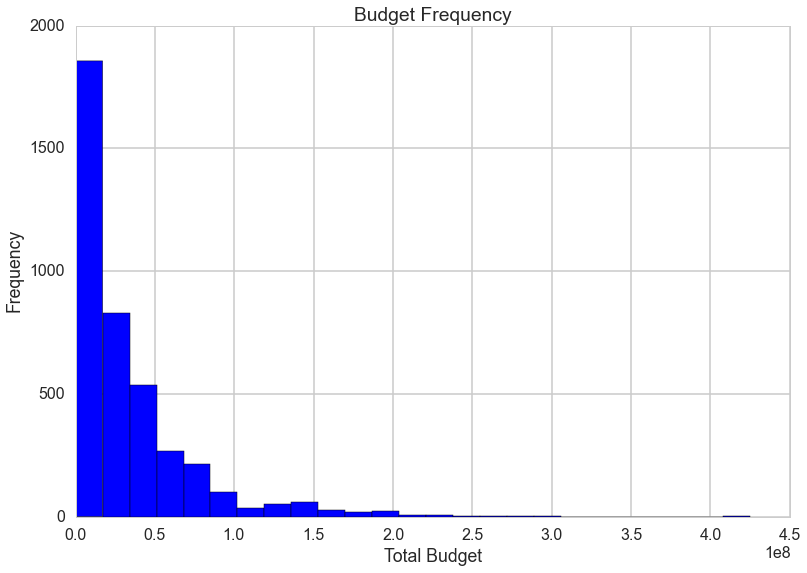

In [131]:
#create histogram of budget
plt.hist(movieframe["budget"], bins = 25, color = "b")
plt.xlabel("Total Budget")
plt.ylabel("Frequency")
plt.title("Budget Frequency")

Finding that this distribution is severely skewed to the right and non-normal, we develop a transformed version of the budget sizes in order to normalize this distribution. After some exploration, it was found that the quartic root transformation was most appropriate.

In [132]:
movieframe["budget_quart"] = movieframe['budget'].apply(lambda x : x ** .25)

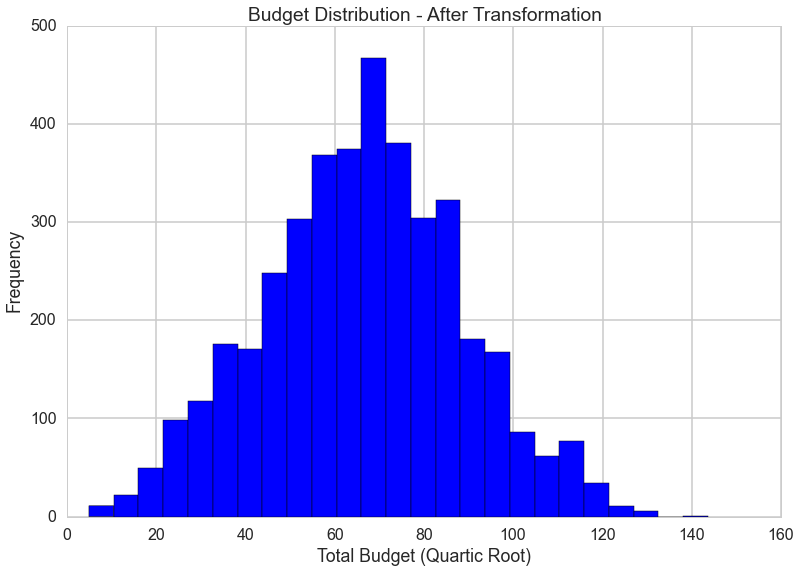

In [133]:
plt.hist(movieframe["budget_quart"], bins = 25, color = "b")
plt.xlabel("Total Budget (Quartic Root)")
plt.ylabel("Frequency")
plt.title("Budget Distribution - After Transformation")

The transformation results in a distribution that is much more normal in shape and can be used for modeling. 

Next, we investigate the distribution of total profits.

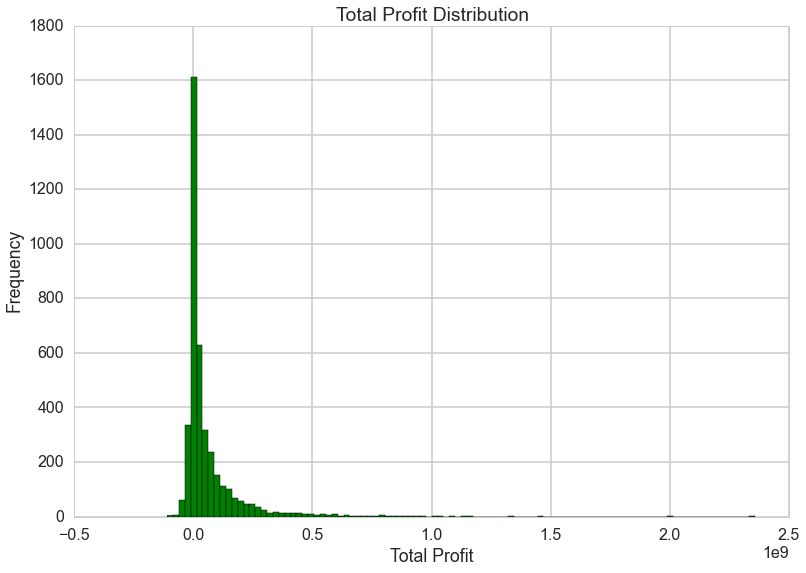

In [134]:
plt.hist(movieframe["total_profits"], bins = 100, color = "g")
plt.xlabel("Total Profit")
plt.ylabel("Frequency")
plt.title("Total Profit Distribution")

As you can see, the profit histogram is extremely right skewed and has negative values.  As such, we choose to transform the data with a rightward shift and a natural log transformation.  While this affects the interpretive value of our resultant predictor, it creates a much more normal and reliable distribution.

In [135]:
a = np.abs(movieframe["total_profits"].min()) + .01
movieframe["profit_transform"] = movieframe['total_profits'].apply(lambda x : np.log(x + a))

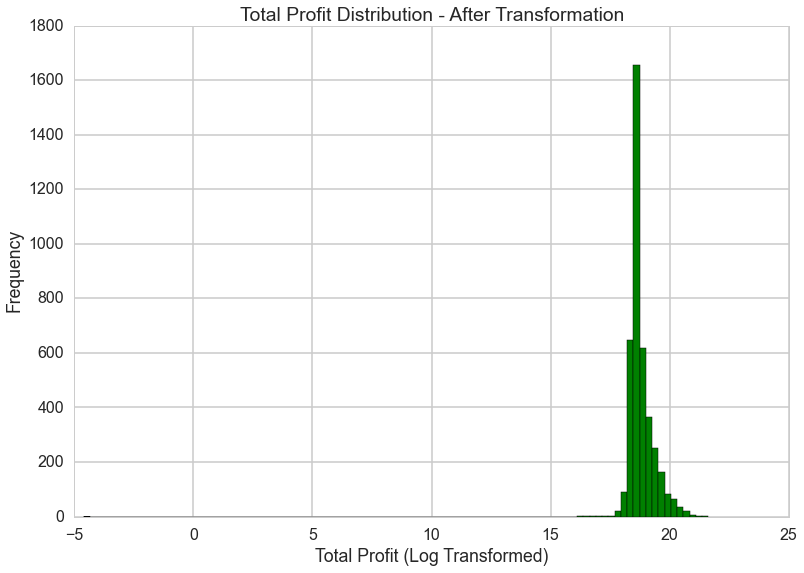

In [136]:
plt.hist(movieframe["profit_transform"], bins = 100, color = "g")
plt.xlabel("Total Profit (Log Transformed)")
plt.ylabel("Frequency")
plt.title("Total Profit Distribution - After Transformation")

This distribution is still slightly right-skewed, but it is a much more normal distribution than the prior distribution. We also notice a severe outlier at -5 on the log scale. We will formally deal with this outlier in a later section.

We apply the same transformation to domestic profits instead of total profits, and we see similar results.

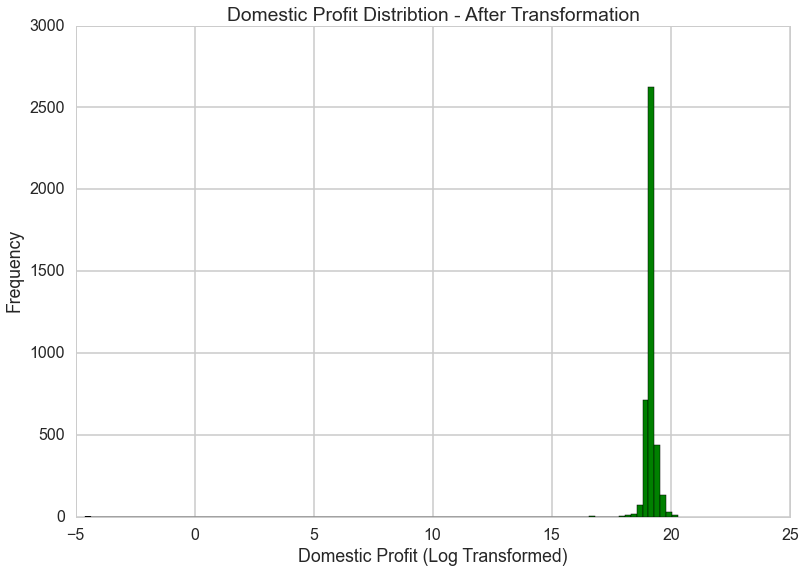

In [137]:
b = np.abs(movieframe["dom_profits"].min()) + .01
movieframe["dom_profit_transform"] = movieframe['dom_profits'].apply(lambda x : np.log(x + b))

plt.hist(movieframe["dom_profit_transform"], bins = 100, color = "g")
plt.xlabel("Domestic Profit (Log Transformed)")
plt.ylabel("Frequency")
plt.title("Domestic Profit Distribtion - After Transformation")

We notice a similar outlier in domestic profit, and it's far enough away from the mean that we believe it is unnatural and should be removed. One of these outliers is for the movie "John Carter," and the other outlier is for the movie "Mars Needs Moms"

In [138]:
# Dropping the outliers
movieframe.drop(['Mars Needs Moms','John Carter','The Lone Ranger'], inplace = True)

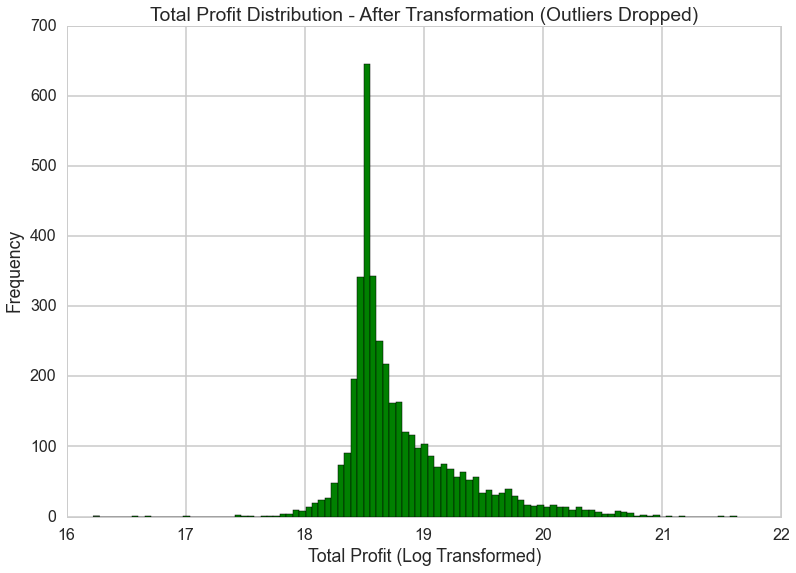

In [141]:
plt.hist(movieframe["profit_transform"], bins = 100, color = "g")
plt.xlabel("Total Profit (Log Transformed)")
plt.ylabel("Frequency")
plt.title("Total Profit Distribution - After Transformation (Outliers Dropped)")

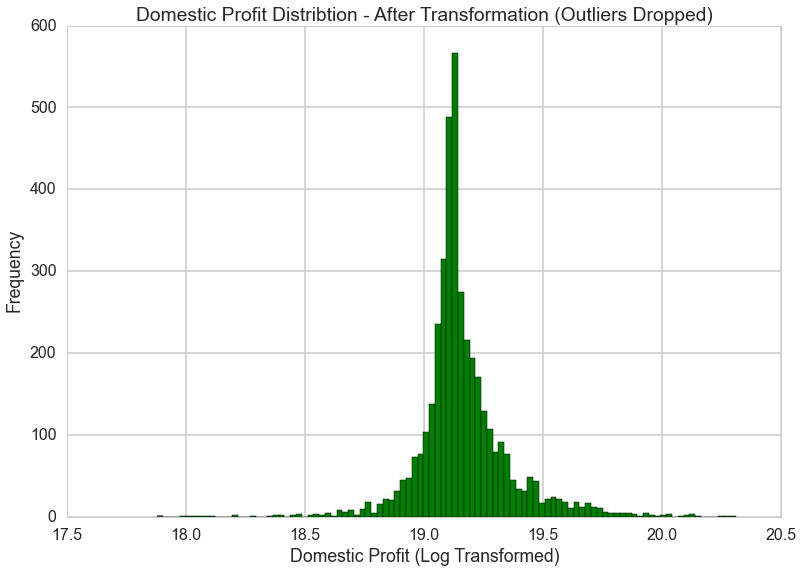

In [143]:
plt.hist(movieframe["dom_profit_transform"], bins = 100, color = "g")
plt.xlabel("Domestic Profit (Log Transformed)")
plt.ylabel("Frequency")
plt.title("Domestic Profit Distribtion - After Transformation (Outliers Dropped)")

Now, we are looking at critic ratings and some relationships between ratings and various metrics.

First, we look at the distribution of critic ratings

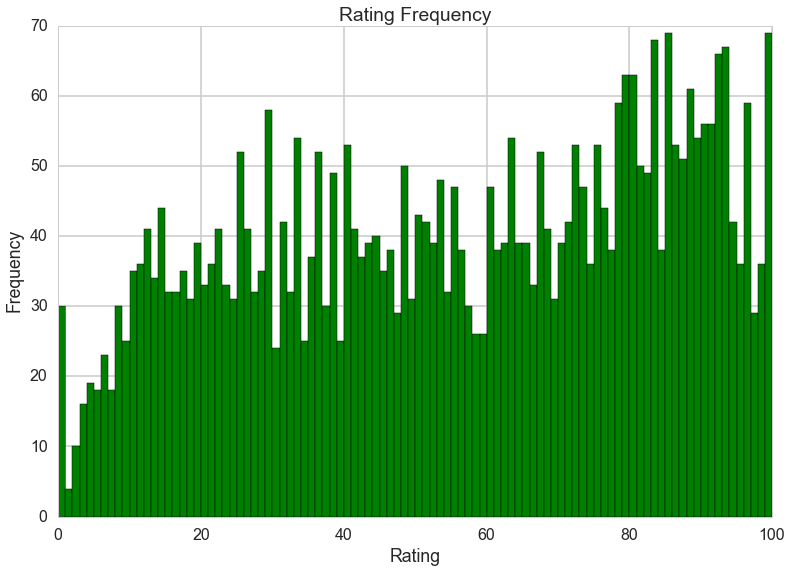

In [113]:
plt.hist(movieframe["critic_rating"], bins = 100, color = "g")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating Frequency")


The critics rating distribution looks somewhat uniform and not particularly skewed in any one direction, so it doesn't require a transformation.

Now we create scatter plots comparing ratings and budgets, respectively, to profits in order to visualize the relationship between ratings and profits as well as budgets and profits. 

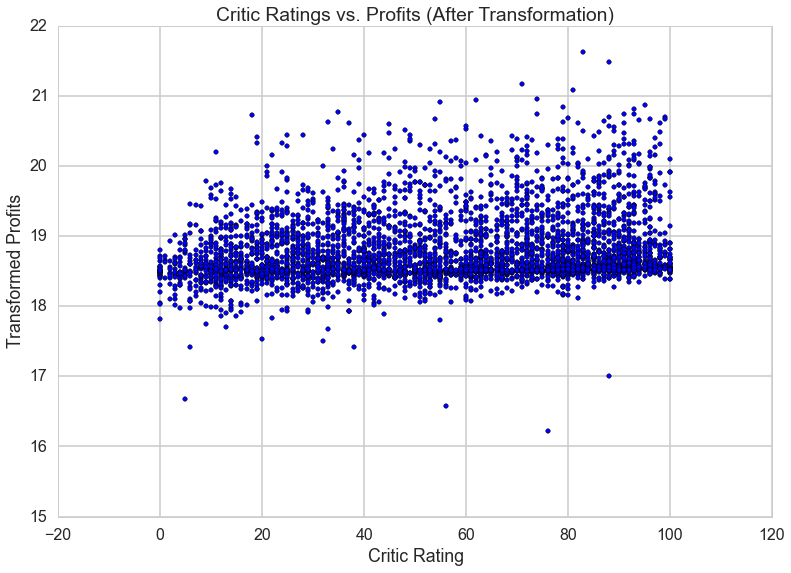

In [149]:
plt.scatter(movieframe["critic_rating"], movieframe["profit_transform"])
plt.title('Critic Ratings vs. Profits (After Transformation)')
plt.ylabel('Transformed Profits')
plt.xlabel('Critic Rating')

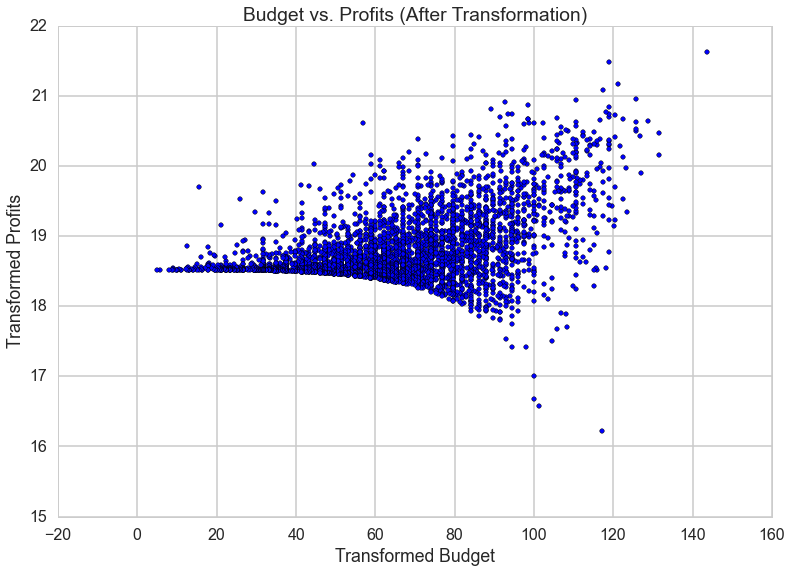

In [150]:
plt.scatter(movieframe["budget_quart"], movieframe["profit_transform"])
plt.title('Budget vs. Profits (After Transformation)')
plt.ylabel('Transformed Profits')
plt.xlabel('Transformed Budget')

Critic rating and movie profits appear to have a slightly positive linear association, with homogenous distribution of error terms. We find that severe heteroskedasticity is present between transformed movie-budgets and transformed profits, which may cause bias in future models. However, having transformed budget already, we are hesitant to transform further. We will proceed even in light of this assumption violation.

Having investigated all of our relevant variables, we perform grand-mean-centering in order to ensure all variables are on the same scale. We also split our dataframe into test and training sets for model training and checking. 

In [151]:
from sklearn import preprocessing
xlist = ['budget','domestic_gross','worldwide_gross','dom_profits', 'total_profits', 'budget_quart', 'profit_transform', 'dom_profit_transform']
movieframe[xlist] = preprocessing.scale(movieframe[xlist])

from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(movieframe.shape[0]), train_size=0.8)
mask=np.ones(movieframe.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

train = movieframe[mask]
test = movieframe[-mask]

In [152]:
movieframe.head()

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,critic_rating,aud_rating,release_date
Avatar,1,9.839007,11.170967,16.269912,6.837617,16.554937,3.477241,5.717157,4.815729,83,82,2009-12-18
Pirates of the Caribbean: At World's End,2,6.700015,4.124359,5.256170,-0.058922,4.337815,2.937726,3.367079,0.036082,45,72,2007-05-25
Spectre,3,6.700015,2.077891,3.976602,-2.829579,2.813795,2.937726,2.720474,-4.916785,64,66,2015-11-06
The Dark Knight Rises,4,6.072217,6.291337,5.988315,3.403625,5.389970,2.810124,3.717164,2.973582,87,90,2012-07-20
Tangled,7,5.695538,2.427900,2.976354,-1.509737,1.910684,2.729329,2.209780,-1.973485,90,87,2010-11-24


In [47]:
print train.profit_transform.mean(), test.profit_transform.mean()

0.00216995293856 -0.00867175499826


##OLS Model Building

Having dealt with all explanatory and dependent variables, we are ready to dive into our research objectives. Our first such objective is to investigate the relationship between movie profitability and Rotten Tomato critic ratings. We start by fitting an OLS model with transformed profit as the dependent variable and critic rating as the sole explanatory variable.

In [170]:
ols_model = ols("profit_transform ~ critic_rating", movieframe).fit()
ols_model
print ols_model.summary()


                            OLS Regression Results                            
Dep. Variable:       profit_transform   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     147.5
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           2.29e-33
Time:                        17:58:51   Log-Likelihood:                -5651.5
No. Observations:                4034   AIC:                         1.131e+04
Df Residuals:                    4032   BIC:                         1.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.3717      0.034    -10.840

From this model, it seems that critic ratings on their own are not exceptional as an explanatory variable for movie profit, explaining only 3.5% of the variation in movie profit numbers. Given that profit numbers for movies are highly variable, as displayed in the scatterplot above, it is likely that the addition of another predictor would great improve the fit of this model. Understanding that movie profit is equal to output(revenue) - input(budget), movie budget is logical variable to control for in modeling profits. We fit this model using our transformed budget variable and display results below.

In [171]:
ols_model2 = ols("profit_transform ~ budget_quart + critic_rating", movieframe).fit()
ols_model2
print ols_model2.summary()

                            OLS Regression Results                            
Dep. Variable:       profit_transform   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     746.6
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          1.46e-276
Time:                        17:59:00   Log-Likelihood:                -5088.4
No. Observations:                4034   AIC:                         1.018e+04
Df Residuals:                    4031   BIC:                         1.020e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.5510      0.030    -18.221

Addition of transformed budget measurements to the model improves the fit greatly, with R-squared increasing to 27% from the previous 3.5%. This improvement, while positive, stil does not provide a great fit to the data, likely due to the size of the data set along with the great degree of variability. The model reports significant t-test statistics for both budget and critic rating, indicating that both of these predictors have an association with profit that differs from 0 in a statistically significant fashion. The coefficients may be interpreted as such: An increase of 1 standard deviation in distance from the mean of the distribution of movie budgets on the quartic-root scale will result in an increase of .4932 standard deviations from the mean of movie profits on the traslated-log scale after controlling for movie ratings. An increase of 1 point in critic ratings will result in an increase of .0099 standard deviations from the mean of movie profits on the traslated-log scale, after controlling for movie budgets. These findings support the hypothesis that some of statistically significant relationship exists between critic rating and move profitability. 

Next we look to examine the impact of being rated "rotten" or "fresh" on profitability. To do so, we start by creating an indicator for rotten versus fresh and add this indicator into our previous model. The fit is outlined below.

In [157]:
movieframe["fresh"] = movieframe.critic_rating>=60

In [91]:
movie58 = movieframe.profit_transform[movieframe.critic_rating==58].values
movie59 = movieframe.profit_transform[movieframe.critic_rating==59].values
movie60 = movieframe.profit_transform[movieframe.critic_rating==60].values
movie61 = movieframe.profit_transform[movieframe.critic_rating==61].values

stats.f_oneway(movie58, movie59, movie60, movie61)

F_onewayResult(statistic=0.81994707531630207, pvalue=0.48503903538574555)

In [169]:
ols_model = ols("profit_transform ~ fresh + critic_rating + budget_quart", movieframe).fit()
ols_model
print ols_model.summary()

                            OLS Regression Results                            
Dep. Variable:       profit_transform   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     498.3
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          2.16e-275
Time:                        17:58:15   Log-Likelihood:                -5087.7
No. Observations:                4034   AIC:                         1.018e+04
Df Residuals:                    4030   BIC:                         1.021e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.5754      0.036    -15.847

Based on this initial model in which we control for rating and budget, freshness does not appear to have a relationship with profitability that differs significantly from 0. Furthermore, R-squared in this model remains at 27%, relatively unchanged from our previous model. This indicates that freshness does not add significant predictive power to our model.

Having investigated worldwide profits, we check to see how the relationship varies for domestic profits. Our thinking here is that Rotten Tomatos©, as an American site, may be more popular and thus more influential in the United States. Below is our modified model.

In [172]:
ols_model = ols("dom_profit_transform ~ fresh + critic_rating + budget_quart", movieframe).fit()
ols_model

basemodel = ols("dom_profit_transform ~ budget_quart", movieframe).fit()
print ols_model.summary(), basemodel.rsquared

                             OLS Regression Results                             
Dep. Variable:     dom_profit_transform   R-squared:                       0.060
Model:                              OLS   Adj. R-squared:                  0.059
Method:                   Least Squares   F-statistic:                     85.20
Date:                  Thu, 10 Dec 2015   Prob (F-statistic):           1.90e-53
Time:                          17:59:52   Log-Likelihood:                -5600.0
No. Observations:                  4034   AIC:                         1.121e+04
Df Residuals:                      4030   BIC:                         1.123e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.4994  

At first glance, the findings of this model are quite perplexing. While budget and critic rating do a decent job explaining variation in total worldwide profits, the explanatory power of these variables is, in fact, much *lower* for domestic profits. The explanatory variables critic rating, transformed budget, and freshness category explain approximately 6% of the variation in log-translated domestic profits, compared to 27% of variation in total profits. Similar to the previous model for total profits, the coefficient for freshness category does not differ significantly from 0, indicating that it likely does not add significant predictive power in this case either. Unlike the last model, however, transformed budget measurements do not appear to have a statistically significant relationship with log-translated domestic profits. It appears as though all of the explanatory power of this model, then, is generated by the critics ratings, and we see this in the comparison of R-squared values between the main model and the budget-only model, in which R-squared is equal to .0007. The significance of the relationship between profits and critic ratings appears to hold for both profit measurements. 

Given the evidence of a non-zero linear association between critic rating and profits, we re-examine our methods of modeling this association consider a different approach. In order to dive deeper into this trend, it was decided to create a level 2 data frame in which movies would be grouped by rating, allowing for comparison of mean profit measurements across groups. Such a technique reduces the amount of noise in the data set, allowing for a clearer picture of the overall trend. In the code below, the means of total profit, transformed budget, and transformed total profit are calculated for all movies of a given rating (1- 100) and these means are displayed by scatterplot.

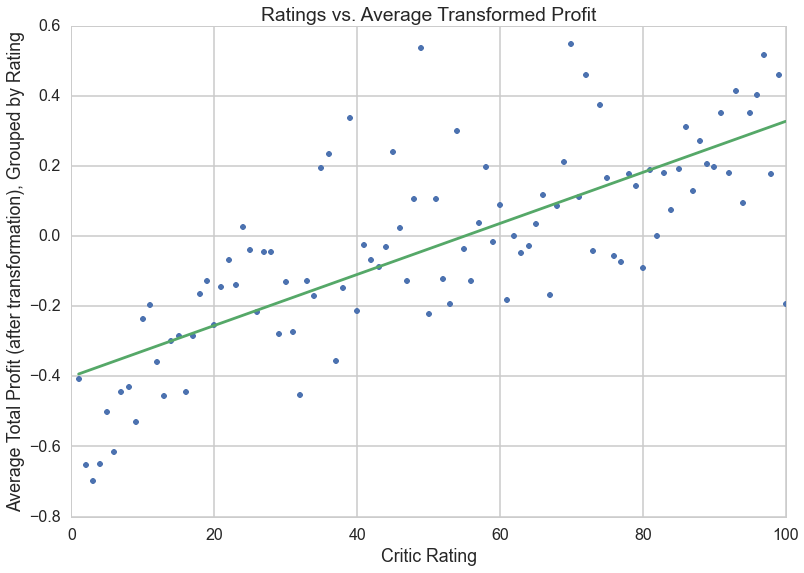

In [187]:
rats = np.arange(100)
rats = rats+1
tp_mean = []
budget_list = []
trp_mean = []
for rat in rats:
    tp_mean.append(movieframe[movieframe.critic_rating==rat].total_profits.mean())
    budget_list.append(movieframe[movieframe.critic_rating==rat].budget_quart.mean())
    trp_mean.append(movieframe[movieframe.critic_rating==rat].profit_transform.mean())
    
m, b = np.polyfit(rats, trp_mean, 1)
y = (m*rats)+ b
plt.plot(rats, trp_mean, '.')
plt.plot(rats, y, '-')
plt.xlabel('Critic Rating')
plt.ylabel('Average Total Profit (after transformation), Grouped by Rating')
plt.title('Ratings vs. Average Transformed Profit ')

The line of best fit highlights a more clear positive linear association between rating and average (transformed) profit. We store these means below in a level 2 dataframe new_movieframe.

In [183]:
fields = ["Ratings", "Total_Profit_Mean", "Transform_Profit_Mean", "Budget_Quart"]
movie_dict = dict(zip(fields, [rats, tp_mean, trp_mean, budget_list]))
new_movieframe = pd.DataFrame(movie_dict)
new_movieframe.head()

,Budget_Quart,Ratings,Total_Profit_Mean,Transform_Profit_Mean
0,-0.215725,1,-0.367916,-0.408172
1,0.026246,2,-0.455638,-0.652182
2,0.383619,3,-0.465732,-0.698701
3,-0.014686,4,-0.455462,-0.650237
4,0.152852,5,-0.340702,-0.502083


In an effort to enumerate the relationship between group-level critic rating and average transformed profit, we fit an OLS model regressing transformed mean profit on transformed mean budget and group level critic rating. For comparative purposes, we also fit the model ratsolo_mod which includes ratings as the sole predictor of profit. 

In [192]:
avgs_model = ols("Transform_Profit_Mean ~ Budget_Quart + Ratings", new_movieframe).fit()
avgs_model

ratsolo_mod = ols("Transform_Profit_Mean ~ Ratings", new_movieframe).fit()
print avgs_model.summary(), ratsolo_mod.rsquared

                              OLS Regression Results                             
Dep. Variable:     Transform_Profit_Mean   R-squared:                       0.680
Model:                               OLS   Adj. R-squared:                  0.674
Method:                    Least Squares   F-statistic:                     103.2
Date:                   Thu, 10 Dec 2015   Prob (F-statistic):           9.53e-25
Time:                           18:45:20   Log-Likelihood:                 43.390
No. Observations:                    100   AIC:                            -80.78
Df Residuals:                         97   BIC:                            -72.96
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0

The model including critic ratings and average budget measurements results in an R-squared value of .680, indicating that 68% of the variation in group-level average transformed profit is explained by the model. Furthermore, the ratings-only model reports an R-squared values of .574, indicating that much of the explanatory nature of this model comes from the group-level ratings. The reported coefficient for ratings in our full model is reported as .0099, identical to the value from the model fit to the individual level data. It seems here, however, that ratings are able to explain far more variation in mean profit numbers than in aggregate profit numbers.

Having investigated the relationship between ratings and profits from the viewpoint of critic ratings, we now check to see if a similar relationship holds in the other direction. We wish to apply a similar method to the one above, in which observations were grouped by critic rating, but with groupings of observations based on total profits. For this analysis, we sort the data in descending order (largest first) and split observations into five evenly spaced categories of profit range. The categories are numbered 1-5, with category 1 indicating that a movie is in the top 20% most profitable movies. We implement this strategy by adding a new column "category" to our sorted dataframe.

In [61]:
profframe = movieframe.sort("total_profits", ascending = False)
lst = [807, 807, 807, 808, 808]
x = range(len(lst))
for i in x:
    cat = ((i * 807)+1) + lst[i]
    profframe.loc[i * 807 : cat,'category'] = i+1

profframe.head()

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,rating,critic_rating,aud_rating,release_date,fresh,category
Avatar,1,425000000,760507625,2783918982,335507625,2358918982,143.581086,21.627229,20.102344,68,83,82,2009-12-18,True,1
Titanic,31,200000000,658672302,2207615668,458672302,2007615668,118.920711,21.473769,20.308680,81,88,69,1997-12-19,True,1
Jurassic World,22,215000000,652198010,1669164161,437198010,1454164161,121.090372,21.170905,20.275633,64,71,79,2015-06-12,True,1
Furious 7,51,190000000,351032910,1516246709,161032910,1326246709,117.405489,21.085613,19.709842,15,81,83,2015-04-03,True,1
The Avengers: Age of Ultron,9,250000000,459005868,1404705868,209005868,1154705868,125.743343,20.958461,19.833975,29,74,85,2015-05-01,True,1


The data is sorted by in order of decreasing profit and divided into categories. We are interested in the mean critic ratings of movies across categories. With only 5 distinct categories, we depart from regression for this step and instead compare the means using a one-way F-test procedure. With this test, we are able to determine whether or not means across all groups differ significantly from one another. Specifically, we are testing the hypothesis

H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> = $\mu$<sub>3</sub>  = $\mu$<sub>4</sub> = $\mu$<sub>5</sub>

against that alternative H<sub>a</sub> that at least one of the means differs significantly from the rest. The results of this test are outlined below.

In [65]:
from scipy import stats

rat1 = profframe.critic_rating[profframe.category==1].values
rat2 = profframe.critic_rating[profframe.category==2].values
rat3 = profframe.critic_rating[profframe.category==3].values
rat4 = profframe.critic_rating[profframe.category==4].values
rat5 = profframe.critic_rating[profframe.category==5].values
stats.f_oneway(rat1, rat2, rat3, rat4, rat5)

F_onewayResult(statistic=60.904918273513331, pvalue=5.0029369447873387e-50)

The results of this F-test lead us to believe that there is some significant difference in the mean critic ratings of movies of the same profit category. We choose to investigate these differences across categories using a pairwise Tukey-HSD procedure. This procedure is carried out using the statsmodels module of python and conducts pairwise t-test comparison of means with correction for multiple comparison.

In [90]:
import statsmodels.sandbox
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd

print pairwise_tukeyhsd(profframe.critic_rating.values, profframe.category.values)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
 1.0    2.0   -5.3643  -9.0633  -1.6654   True 
 1.0    3.0    -4.57    -8.269  -0.8711   True 
 1.0    4.0   -2.8674  -6.5664   0.8315  False 
 1.0    5.0   -19.2654 -22.9621 -15.5687  True 
 2.0    3.0    0.7943  -2.9047   4.4933  False 
 2.0    4.0    2.4969  -1.2021   6.1959  False 
 2.0    5.0   -13.9011 -17.5978 -10.2044  True 
 3.0    4.0    1.7026  -1.9964   5.4016  False 
 3.0    5.0   -14.6954 -18.3921 -10.9987  True 
 4.0    5.0   -16.398  -20.0947 -12.7013  True 
-----------------------------------------------


The results of the Tukey-HSD procedure prove quite interesting. As we are most concerned with comparisons between adjacent profit groups (1 & 2, 2 & 3, etc), we look to these comparisons first. With 95% confidence we can say that movies with profits in the top 20% achieved average ratings that were, on average, between 1.6 and 9.0 points higher than movies with profits in the top 40%, corresponding to a statistically significant difference. No significant difference was reported for groups 2 and 3 (top 40% vs. top 60%) nor for groups 3 and 4 (top 60% vs. top 80%), but movies in the top 80%, group 4, had ratings that were, on average, 12.7 to 20.1 points higher than movies in the bottom 20%. These differences provide further evidence in support of the positive relationship between critic ratings and profit. 

##Conclusion

Our original objectives at the start of this analysis were to (a): Evaluate the significance of the relationship between critic rating and profitability and (b): Determine the impact of a "rotten" rating vs a "fresh" rating. With regards to the latter, our findings provide little evidence to support the hypothesis that "freshness" status has any significant effect on movie profitability. Using a number of regression models and F-test procedures on grouped data, we were unable to find significant evidence of any such impact related to these categorizations. Our findings are, however, in line with the hypothesis that a statistically significant relationship exists between 